## Decision Tree for Segmentation

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import warnings

%matplotlib inline

The decision tree work in this notebook looks to use a decision tree to classify the segments developed in the previous segmentation notebook. 

Rules from how the decision tree splits nodes can then be taken and used in SQL to code up subscribers directly on Google Big Query.

The original segmentation is first repeated to achieve the segment labels

In [121]:
dat = pd.read_csv('data for segmentation_130519.csv') #from file where seg_data is kept
print(dat.shape)
dat.head()

(123587, 167)


,eval_date,pid,pid_age,cross_platform,current_sub_length,current_sub_rank,price_per_term,paypal,credit_card,direct_debit,...,occupation_skilled_manual_worker,occupation_self_employed,occupation_housewife,children_at_home,has_stocks_and_shares,isba_desc,financial_acorn_type_desc,acorn_type_desc,ts_number,postcode
0,08/05/2019,000068d2-5ce0-4b19-9832-8884568391be,601,0,-601.0,1.0,95.37,0,1,0,...,-1,-1,-1,-1,-1,NaN,NaN,NaN,TS2601020,NaN
1,08/05/2019,0000883f-9856-413c-9e32-af6e351470e5,85,0,-71.0,1.0,104.04,0,1,0,...,-1,-1,-1,-1,-1,London,"Young welloff private renters, less financiall...",Business areas without resident population,TS5781221,WC1V 6PX
2,08/05/2019,00008fcd-031a-4b8e-abf6-c98ba9e04179,45,0,-31.0,1.0,104.04,0,1,0,...,0,1,0,1,1,Wales and the West,"Older professional families, spending and inve...",Wealthy countryside commuters,TS6075007,SN15 5PH
3,08/05/2019,0000d39c-81af-4364-b636-7f87ae1f982f,196,0,-196.0,2.0,80.00,0,1,0,...,0,0,0,0,1,Lancashire,"Wealthiest middleaged couples, many investments",Wealthy countryside commuters,TS2064416,CH60 9HR
4,08/05/2019,0001c9df-ea30-4295-86b7-f0d4790b5621,198,1,-198.0,1.0,0.00,0,0,0,...,0,0,0,0,1,Southern,"Wealthiest middleaged couples, many investments",Large house luxury,TS1375429,RH1 4JJ


In [112]:
dat2 = pd.read_csv('seg_2506.csv') #from file where seg_data is kept
print(dat.shape)
dat.head()

(123587, 168)


,eval_date,pid,pid_age,cross_platform,current_sub_length,current_sub_rank,price_per_term,paypal,credit_card,direct_debit,...,occupation_self_employed,occupation_housewife,children_at_home,has_stocks_and_shares,isba_desc,financial_acorn_type_desc,acorn_type_desc,ts_number,postcode,seg
0,08/05/2019,000068d2-5ce0-4b19-9832-8884568391be,601,0,-601.0,1.0,95.37,0,1,0,...,-1,-1,-1,-1,NaN,NaN,NaN,TS2601020,NaN,2
1,08/05/2019,0000883f-9856-413c-9e32-af6e351470e5,85,0,-71.0,1.0,104.04,0,1,0,...,-1,-1,-1,-1,London,"Young welloff private renters, less financiall...",Business areas without resident population,TS5781221,WC1V 6PX,4
2,08/05/2019,00008fcd-031a-4b8e-abf6-c98ba9e04179,45,0,-31.0,1.0,104.04,0,1,0,...,1,0,1,1,Wales and the West,"Older professional families, spending and inve...",Wealthy countryside commuters,TS6075007,SN15 5PH,2
3,08/05/2019,0000d39c-81af-4364-b636-7f87ae1f982f,196,0,-196.0,2.0,80.00,0,1,0,...,0,0,0,1,Lancashire,"Wealthiest middleaged couples, many investments",Wealthy countryside commuters,TS2064416,CH60 9HR,0
4,08/05/2019,0001c9df-ea30-4295-86b7-f0d4790b5621,198,1,-198.0,1.0,0.00,0,0,0,...,0,0,0,1,Southern,"Wealthiest middleaged couples, many investments",Large house luxury,TS1375429,RH1 4JJ,5


Chosen variables for segmentation. 

In [122]:
dat_num = dat.fillna(0)
dat_num = dat_num[[
 'cross_platform',
 'current_sub_length',
 'current_sub_rank',
 'price_per_term',
 'paypal',
 'credit_card',
 'direct_debit',
 'annual',
 'monthly',
 'weekday_prop',
    'weekend_prop',
 'lan_wifi_prop',
    'mob_prop',
 'days_since_last_seen',
 'visit_week',
 'pv_week',
 'pv_premium',
 'prop_premium_pv',
 'story_types_total',
 'Politics_pv',
 'Sport_pv',
 'News_pv',
 'Business_pv',
 'Lifestyle_pv',
 'Other_pv',
 'content_types',
 'channels',
 'device_types',
#'email_sign_up',
'unsubscribed_flag',   
 #'newsletter_sign_up',
 #'distinct_clicks_sent_ratio',
 'clicks_sent_ratio',
 'distinct_clicks_to_open_ratio',
 #'distinct_clicks_to_distinct_open_ratio',
 #'distinct_open_to_sent',
 'open_to_sent',   
 'business_email',
 'football_email',
 'lifestyle_email',
 'fashion_email',
 'news_email',
 'politics_email',
 'rugby_email',
 'sports_email',
 'tech_email',
 'connect_email',
 'travel_email']]

In [98]:
from sklearn.cluster import KMeans

x = dat_num.copy()

pca_col = list(x.columns)

scaler = StandardScaler().fit(x[pca_col])
df_scaled = pd.DataFrame(scaler.transform(x[pca_col]))

#for merging together position and name index
df_scaled.reset_index(drop=True, inplace=True)

pca = PCA(n_components=0.8)  # consider enough components to explain 80% of the variance
pca.fit(df_scaled)

pcscores = pd.DataFrame(pca.transform(df_scaled))
pcscores.columns = ['PC'+str(i+1) for i in range(len(pcscores.columns))]

seg_pca = pcscores #all components for 80% variance
#seg_pca = pcscores.iloc[:,:n] # select the first n components

Run the K Means Clustering determined in the previous notebook

In [27]:
k=7

In [28]:
km = KMeans(n_clusters=k,  random_state=123, init='k-means++', n_init=50)
km = km.fit(seg_pca)
seg_pca['labels'] = km.predict(seg_pca)

In [29]:
seg_pca.labels.value_counts()

4    33634
0    24349
3    21761
1    19524
6    10380
2     7575
5     6364
Name: labels, dtype: int64

In [11]:
seg_pca.labels.value_counts()

4    29911
2    28534
0    27046
3    19215
1    11187
5     7267
6     6391
Name: labels, dtype: int64

In [30]:
seg_pca.labels.value_counts()/len(seg_pca)

4    0.272148
0    0.197019
3    0.176078
1    0.157978
6    0.083989
2    0.061293
5    0.051494
Name: labels, dtype: float64

Assign the segment labels to the original data set

In [31]:
dat['seg_label'] = seg_pca['labels']

remove the columns as before the segmentation

In [ ]:
dat_num = dat.copy()
dat_num = dat_num.fillna(0)

X = dat_num[[
 'cross_platform',
 'current_sub_length',
 'current_sub_rank',
 'price_per_term',
 'paypal',
 'credit_card',
 'direct_debit',
 'annual',
 'monthly',
 'weekday_prop',
 'weekend_prop',
 'lan_wifi_prop',
 'mob_prop',
 'days_since_last_seen',
 'visit_week',
 'pv_week',
 'pv_premium',
 'prop_premium_pv',
 'story_types_total',
 'Politics_pv',
 'Sport_pv',
 'News_pv',
 'Business_pv',
 'Lifestyle_pv',
 'Other_pv',
 'content_types',
 'channels',
 'device_types',
 'unsubscribed_flag',
 'clicks_sent_ratio',
 'distinct_clicks_to_open_ratio',
 'open_to_sent',   
 'business_email',
 'football_email',
 'lifestyle_email',
 'fashion_email',
 'news_email',
 'politics_email',
 'rugby_email',
 'sports_email',
 'tech_email',
 'connect_email',
 'travel_email']]

y = dat['seg_label'].copy()

## Decision tree allocation of segments

### Train/Test split

The data set is split into a train and test set for tuning the decision tree

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

A decision tree can have a range of different parameters tuned but for this work only the depth of the tree will be tuned.

### Train Accuracy - changing max depth

In [15]:
from sklearn import tree

depth = []
depth.append(0)
for i in range(1,40):
    clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=i, random_state=42)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_train)

    # Model Accuracy
    depth.append(metrics.accuracy_score(y_train, y_pred))
print(depth)

[0, 0.41625245636342617, 0.6217200323662004, 0.6825569298347012, 0.815131198705352, 0.8675066466304473, 0.8804993642353485, 0.8995260663507109, 0.914518552768466, 0.9274650329441683, 0.9405502254074674, 0.9508033753323315, 0.9603860825338111, 0.9697722806611953, 0.9791122413593805, 0.9857588718067275, 0.99086810773321, 0.994740492428621, 0.9973529071783609, 0.9988325049127269, 0.9996069818518091, 0.9998381689978038, 0.9999306438562016, 0.9999884406427003, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


### Test Accuracy - changing max depth

In [16]:
depth_test = []
depth_test.append(0)
for i in range(1,40):
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=i, random_state=42)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    # Model Accuracy
    depth_test.append((metrics.accuracy_score(y_test, y_pred)))
print(depth_test)

[0, 0.4158373115408474, 0.613533996817434, 0.6726542061116055, 0.8093696901043774, 0.8600480081991532, 0.8719152034954284, 0.8896081128462389, 0.9026350567737411, 0.9122906384011651, 0.9206246460069585, 0.9252096987350649, 0.9260188256870836, 0.9257221458046767, 0.927286457911913, 0.9280146721687299, 0.928230439355935, 0.9280686139655312, 0.927798904981525, 0.9280146721687299, 0.9272325161151118, 0.9276910213879225, 0.9283383229495374, 0.9273403997087143, 0.927286457911913, 0.927286457911913, 0.927286457911913, 0.927286457911913, 0.927286457911913, 0.927286457911913, 0.927286457911913, 0.927286457911913, 0.927286457911913, 0.927286457911913, 0.927286457911913, 0.927286457911913, 0.927286457911913, 0.927286457911913, 0.927286457911913, 0.927286457911913]


### Plot of Train and Test Accuracy

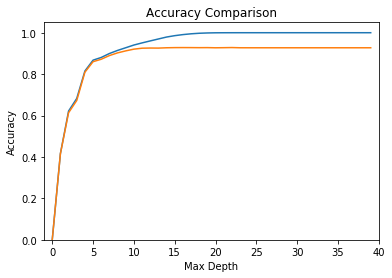

In [17]:
import matplotlib.pyplot as plt 
#depth_test = pd.DataFrame(depth_test)
plt.xlim([-1, 40])
plt.ylim([0,1.05])
plt.plot(depth)
plt.plot(depth_test)
plt.title('Accuracy Comparison')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')

plt.show()

From the graph the difference between train and test accuracy begins to split at a depth of 6, where the training set is starting to overfit. Therefore this depth shall be chosen for the tree to develop the rules for allocation segments from.

Fitting a tree with a depth of 6

In [18]:
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=6, random_state=42)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Model Accuracy
metrics.accuracy_score(y_test, y_pred)

0.8719152034954284

## Confusion Matrix - Test Set

In [19]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))

,0,1,2,3,4,5,6
0,5419,215,33,305,1419,0,76
1,11,5428,176,89,98,79,48
2,13,30,2112,61,42,0,17
3,59,129,39,6110,44,0,31
4,818,56,195,54,8777,0,128
5,0,141,0,0,8,1699,0
6,35,23,62,72,143,0,2783


As can be seen from the confusion matrix the majority of misclassification occurs between segments 0 and 4. These segments are the younger demographics who are less engaged and show similar profiles. 

## Allocating rules for assigning segments

Code to print out rules for how the tree is splitting.

In [20]:
depth_tree = 6

In [21]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):

    '''
    Outputs a decision tree model as a Python function

    Parameters:
    -----------
    tree: decision tree model
    The decision tree to represent as a function
    feature_names: list
    The feature names of the dataset used for building the decision tree
    '''

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, depth_tree)

In [22]:
tree_to_code(clf, list(X_train.columns))

def tree(cross_platform, current_sub_length, current_sub_rank, price_per_term, paypal, credit_card, direct_debit, annual, monthly, weekday_prop, weekend_prop, lan_wifi_prop, mob_prop, days_since_last_seen, visit_week, pv_week, pv_premium, prop_premium_pv, story_types_total, Politics_pv, Sport_pv, News_pv, Business_pv, Lifestyle_pv, Other_pv, content_types, channels, device_types, unsubscribed_flag, clicks_sent_ratio, distinct_clicks_to_open_ratio, open_to_sent, business_email, football_email, lifestyle_email, fashion_email, news_email, politics_email, rugby_email, sports_email, tech_email, telegraph_connect_email, travel_email):
            if story_types_total <= 6.5:
              if annual <= 0.5:
                if mob_prop <= 0.3905574530363083:
                  if channels <= 6.5:
                    if weekend_prop <= 0.42740046977996826:
                      if channels <= 4.5:
                        return [[7.929e+03 7.000e+00 1.700e+01 1.000e+00 2.010e+02 0.000e+00 1.600e

As some of the decision branches return the same cluster regardless of the result from the split, the code can be reduced to the following:

In [99]:
def assign_cluster(df):
    if df['story_types_total'] <= 6.5:
        if df['annual'] <= 0.5:
            if df['mob_prop'] <= 0.3905574679374695:
                if df['channels'] <= 6.5:
                    if df['weekend_prop'] <= 0.42740046977996826:
                        cluster = 0
                    else:  # if weekend_prop > 0.42740046977996826
                        cluster = 4
                else:  # if channels > 6.5
                    if df['visit_week'] <= 11.225000381469727:
                        if df['weekday_prop'] <= 0.5590727925300598:
                            cluster = 4
                        else:  # if weekday_prop > 0.5590727925300598
                            cluster = 2
                    else:  # if visit_week > 11.225000381469727
                        cluster = 2
            else:  # if mob_prop > 0.3905574679374695
                if df['weekend_prop'] <= 0.49766355752944946:
                    if df['lan_wifi_prop'] <= 0.4932882785797119:
                        cluster = 6
                    else:  # if lan_wifi_prop > 0.4932882785797119
                        if df['channels'] <= 7.5:
                            cluster = 6
                        else:  # if channels > 7.5
                            cluster = 2
                else:  # if weekend_prop > 0.49766355752944946
                    if df['weekend_prop'] <= 0.8032258152961731:
                        if df['mob_prop'] <= 0.7527778148651123:
                            cluster = 4
                        else:  # if mob_prop > 0.7527778148651123
                            cluster = 6
                    else:  # if weekend_prop > 0.8032258152961731
                        cluster = 4
        else:  # if annual > 0.5
            if df['lan_wifi_prop'] <= 0.545569896697998:
                if df['lan_wifi_prop'] <= 0.37574005126953125:
                    if df['weekday_prop'] <= 0.3842105269432068:
                        cluster = 4
                    else:  # if weekday_prop > 0.3842105269432068
                        cluster = 6
                else:  # if lan_wifi_prop > 0.37574005126953125
                    if df['channels'] <= 6.5:
                        if df['weekend_prop'] <= 0.489130437374115:
                            cluster = 6
                        else:  # if weekend_prop > 0.489130437374115
                            cluster = 4
                    else:  # if channels > 6.5
                        cluster = 3
            else:  # if lan_wifi_prop > 0.545569896697998
                if df['visit_week'] <= 3.200000047683716:
                    if df['weekend_prop'] <= 0.4328829050064087:
                        if df['weekday_prop'] <= 0.988095223903656:
                            cluster = 3
                        else:  # if weekday_prop > 0.988095223903656
                            cluster = 0
                    else:  # if weekend_prop > 0.4328829050064087
                        cluster = 4
                else:  # if visit_week > 3.200000047683716
                    if df['channels'] <= 6.5:
                        if df['prop_premium_pv'] <= 0.9511904716491699:
                            cluster = 3
                        else:  # if prop_premium_pv > 0.9511904716491699
                            cluster = 1
                    else:  # if channels > 6.5
                        cluster = 3
    else:  # if story_types_total > 6.5
        if df['pv_premium'] <= 3314.5:
            if df['prop_premium_pv'] <= 0.8850110173225403:
                if df['annual'] <= 0.5:
                    if df['lan_wifi_prop'] <= 0.5211313962936401:
                        cluster = 6
                    else:  # if lan_wifi_prop > 0.5211313962936401
                        if df['price_per_term'] <= 23.815000534057617:
                            cluster = 3
                        else:  # if price_per_term > 23.815000534057617
                            cluster = 2
                else:  # if annual > 0.5
                    if df['pv_premium'] <= 757.5:
                        if df['mob_prop'] <= 0.5471806526184082:
                            cluster = 3
                        else:  # if mob_prop > 0.5471806526184082
                            cluster = 6
                    else:  # if pv_premium > 757.5
                        if df['lan_wifi_prop'] <= 0.2789081335067749:
                            cluster = 6
                        else:  # if lan_wifi_prop > 0.2789081335067749
                            cluster = 1
            else:  # if prop_premium_pv > 0.8850110173225403
                if df['pv_premium'] <= 676.5:
                    if df['mob_prop'] <= 0.4073646366596222:
                        if df['weekend_prop'] <= 0.4630604386329651:
                            cluster = 1
                        else:  # if weekend_prop > 0.4630604386329651
                            cluster = 4
                    else:  # if mob_prop > 0.4073646366596222
                        if df['weekend_prop'] <= 0.5697768926620483:
                            cluster = 6
                        else:  # if weekend_prop > 0.5697768926620483
                            cluster = 4
                else:  # if pv_premium > 676.5
                    if df['mob_prop'] <= 0.44873690605163574:
                        cluster = 1
                    else:  # if mob_prop > 0.44873690605163574
                        if df['mob_prop'] <= 0.7834030389785767:
                            cluster = 1
                        else:  # if mob_prop > 0.7834030389785767
                            cluster = 6
        else:  # if pv_premium > 3314.5
            if df['pv_premium'] <= 3986.5:
                if df['Business_pv'] <= 291.5:
                    if df['Sport_pv'] <= 485.0:
                        cluster = 1
                    else:  # if Sport_pv > 485.0
                        cluster = 5
                else:  # if Business_pv > 291.5
                    if df['pv_week'] <= 913.375:
                        cluster = 5
                    else:  # if pv_week > 913.375
                        cluster = 5
            else:  # if pv_premium > 3986.5
                if df['pv_premium'] <= 4251.5:
                    if df['Business_pv'] <= 249.5:
                        cluster = 5
                    else:  # if Business_pv > 249.5
                        cluster = 5
                else:  # if pv_premium > 4251.5
                    if df['Sport_pv'] <= 2.5:
                        cluster = 5
                    else:  # if Sport_pv > 2.5
                        cluster = 5
    return(cluster)

Accuracy on the test set based on using this function.

In [123]:
X_test = dat_num
code_test = X_test.apply(lambda x: assign_cluster(x), axis=1)

In [87]:
metrics.accuracy_score(seg_pca.labels, code_test)

0.8779240535007727

The correlation matrix from the coded segments and labels

In [64]:
pd.DataFrame(metrics.confusion_matrix(seg_pca.labels, code_test))

,0,1,2,3,4,5,6
0,17740,702,75,1031,4540,0,261
1,22,17994,565,266,324,228,125
2,36,90,7090,156,154,0,49
3,163,372,144,20851,124,0,107
4,2702,192,646,128,29586,0,380
5,0,434,0,3,18,5907,2
6,83,100,181,222,461,1,9332


In [116]:
dat2['seg'] = code_test
dat[['pid','seg']].to_csv('pid_seg_orig.csv')
dat_comb = pd.merge(dat, dat2, on=['pid'])

In [119]:
pd.DataFrame(metrics.confusion_matrix(dat_comb.seg_x, dat_comb.seg_y))

,0,1,2,3,4,5,6
0,8383,144,3111,419,2042,9,1241
1,150,16426,189,270,667,1108,338
2,2671,185,28229,97,847,19,1444
3,391,285,64,20357,408,6,555
4,1981,634,801,396,1759,4,633
5,0,825,7,6,3,5205,5
6,1091,270,1325,517,621,21,4906


## Comparison in % split of segments to original segmentation

Split of segments with new rules

In [17]:
round(code_test.value_counts()/len(code_test),2)

4    0.29
3    0.18
0    0.17
1    0.15
6    0.09
2    0.08
5    0.05
dtype: float64

Split from original segmentation

In [28]:
round(dat['seg_label'].value_counts()/len(dat),2)

4    0.27
0    0.20
3    0.18
1    0.16
6    0.08
2    0.06
5    0.05
Name: seg_label, dtype: float64

The splits of clusters are similar and it appears that the biggest misclassification is between 0 and 4 (which are the two youngest segments) and suggests they share similar behaviours.